In [330]:
import sys 
sys.path.insert(0, "home/icb/alessandro.palma/")  # this depends on the notebook depth and must be adapted per notebook
import numpy as np
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd 
import os
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

In [331]:
# Name of the dataset 
dataset_name = 'BBBC021'
data_dir = '/lustre/groups/ml01/workspace/alessandro.palma/imCPA/fluorescence/metadata_processed/dataset'

# Get the training and ood splits (containing the whole set of drugs in the dataset)
dataset = pd.read_csv(os.path.join(data_dir, 'dataset_splits.csv'))

In [414]:
# drug2smile = {drug: smile for drug, smile in zip(dataset.CPD_NAME, dataset.SMILES)}
# drug_names = np.sort(np.unique(dataset.CPD_NAME))  # Sorted drug names
# moa_names = np.sort(np.unique(dataset.MOA))  # Sorted MOA names 
# smile_names = np.array([drug2smile[drug] for drug in drug_names])  # Sorted smile names based on drug sorting 
# print(list(zip(drug_names,smile_names)))

In [332]:
smiles = np.unique(dataset.SMILES)

In [333]:
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator

In [334]:
# Create the generator for rdkit features 
generator = MakeGenerator(("RDKit2D",))

In [335]:
for name, numpy_type in generator.GetColumns():
    print(f"{name}({numpy_type.__name__})")

RDKit2D_calculated(bool)
BalabanJ(float64)
BertzCT(float64)
Chi0(float64)
Chi0n(float64)
Chi0v(float64)
Chi1(float64)
Chi1n(float64)
Chi1v(float64)
Chi2n(float64)
Chi2v(float64)
Chi3n(float64)
Chi3v(float64)
Chi4n(float64)
Chi4v(float64)
EState_VSA1(float64)
EState_VSA10(float64)
EState_VSA11(float64)
EState_VSA2(float64)
EState_VSA3(float64)
EState_VSA4(float64)
EState_VSA5(float64)
EState_VSA6(float64)
EState_VSA7(float64)
EState_VSA8(float64)
EState_VSA9(float64)
ExactMolWt(float64)
FpDensityMorgan1(float64)
FpDensityMorgan2(float64)
FpDensityMorgan3(float64)
FractionCSP3(float64)
HallKierAlpha(float64)
HeavyAtomCount(float64)
HeavyAtomMolWt(float64)
Ipc(float64)
Kappa1(float64)
Kappa2(float64)
Kappa3(float64)
LabuteASA(float64)
MaxAbsEStateIndex(float64)
MaxAbsPartialCharge(float64)
MaxEStateIndex(float64)
MaxPartialCharge(float64)
MinAbsEStateIndex(float64)
MinAbsPartialCharge(float64)
MinEStateIndex(float64)
MinPartialCharge(float64)
MolLogP(float64)
MolMR(float64)
MolWt(float64)

In [336]:
n_jobs = 16
data = Parallel(n_jobs=n_jobs)(delayed(generator.process)(smile) for smile in smiles )

In [337]:
len(data[0])

201

In [338]:
embedding = np.array(data)

Check for the presence of nans or infinity

In [339]:
# Check for nans
drug_idx, feature_idx = np.where(np.isnan(embedding))
print(f'drug_idx:\n {drug_idx}')
print(f'feature_idx:\n {feature_idx}')

drug_idx:
 [29 29 29 29]
feature_idx:
 [40 42 44 46]


In [340]:
drug_idx_infs, feature_idx_infs = np.where(np.isinf(embedding))
print(f'drug_idx:\n {drug_idx_infs}')
print(f'feature_idx:\n {feature_idx_infs}')

drug_idx:
 []
feature_idx:
 []


In [341]:
drug_idx = np.concatenate((drug_idx, drug_idx_infs))
feature_idx = np.concatenate((feature_idx, feature_idx_infs))

In [342]:
# Features where the data has nan values
np.array(generator.GetColumns())[np.unique(feature_idx)]

array([['MaxAbsPartialCharge', <class 'numpy.float64'>],
       ['MaxPartialCharge', <class 'numpy.float64'>],
       ['MinAbsPartialCharge', <class 'numpy.float64'>],
       ['MinPartialCharge', <class 'numpy.float64'>]], dtype=object)

In [343]:
# Check if indeed the content is NaN 
embedding[drug_idx, feature_idx] 

array([nan, nan, nan, nan])

In [344]:
# Turn values to 0
embedding[drug_idx, feature_idx] = 0

In [345]:
embedding.shape

(35, 201)

In [346]:
embedding

array([[1.00000000e+00, 1.48570577e+00, 1.97632897e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.46809486e-01],
       [1.00000000e+00, 1.38744766e+00, 2.28034627e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.29786194e-01],
       [1.00000000e+00, 2.35135123e+00, 7.99282308e+02, ...,
        0.00000000e+00, 0.00000000e+00, 7.46761834e-01],
       ...,
       [1.00000000e+00, 1.96860059e+00, 9.16871713e+02, ...,
        6.00000000e+00, 0.00000000e+00, 1.39316778e-01],
       [1.00000000e+00, 1.84369326e+00, 1.09130210e+03, ...,
        0.00000000e+00, 0.00000000e+00, 4.16226728e-01],
       [1.00000000e+00, 2.05243415e+00, 9.42959069e+02, ...,
        0.00000000e+00, 0.00000000e+00, 5.32981213e-01]])

## Save and normalize

In [347]:
# Convert to df
df = pd.DataFrame(data=embedding, index=smiles, columns=[f'latent_{i}' for i in range(embedding.shape[1])]) 

# Drop first feature from generator (RDKit2D_calculated)
df.drop(columns=['latent_0'], inplace=True)

# Drop columns with 0 standard deviation
threshold = 0.01
columns=[f'latent_{idx+1}' for idx in np.where(df.std() <= threshold)[0]]
print(f'Deleting columns with std<={threshold}: {columns}')
df.drop(columns=[f'latent_{idx+1}' for idx in np.where(df.std() <= 0.01)[0]], inplace=True)

Deleting columns with std<=0.01: ['latent_61', 'latent_84', 'latent_90', 'latent_103', 'latent_119', 'latent_127', 'latent_129', 'latent_133', 'latent_134', 'latent_135', 'latent_137', 'latent_143', 'latent_146', 'latent_147', 'latent_148', 'latent_150', 'latent_152', 'latent_153', 'latent_157', 'latent_158', 'latent_160', 'latent_161', 'latent_164', 'latent_165', 'latent_168', 'latent_171', 'latent_172', 'latent_176', 'latent_177', 'latent_178', 'latent_182', 'latent_183', 'latent_187', 'latent_189', 'latent_191', 'latent_192', 'latent_193', 'latent_194', 'latent_196', 'latent_199']


In [348]:
# Control if the right columns were removed
np.where(df.std() <= threshold)

(array([], dtype=int64),)

In [349]:
# Normalize features 
normalized_df=(df-df.mean())/df.std()

In [350]:
normalized_df.index

Index(['CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]2[C@H](OC(=O)c4ccccc4)[C@]5(O)C[C@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c6ccccc6)C(=C([C@@H](O)C3=O)C5(C)C)C',
       'CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C@@]3(OC(=O)C)[C@H]2[C@H](OC(=O)c4ccccc4)[C@]5(O)C[C@H](OC(=O)[C@H](O)[C@@H](NC(=O)c6ccccc6)c7ccccc7)C(=C1C5(C)C)C',
       'CC(C)(C)n1nc(c2ccc(Cl)cc2)c3c(N)ncnc13',
       'CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C=O',
       'CC(C)[C@H](O)C1(NC(=O)[C@H](C)[C@@H]1O)C(=O)SC[C@H](NC(=O)C)C(=O)O',
       'CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2',
       'CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H]12',
       'CCC(C)C(NC(=O)OCc1ccccc1)C(=O)NC(CCC(=O)OC(C)(C)C)C(=O)NC(C)C(=O)NC(CC(C)C)C=O',
       'CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC4NCCc5cc(OC)c(OC)cc45',
       'CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)C)C=O',
       'CCC\\C=C\\C=C\\C(=O)O[C@H]1\\C(=C\\C(=O)OC)\\C[C@H]2C[C@@H](OC(=O)C[C@H](O)C[C@@

In [351]:
model_name = 'rdkit2D'
fname = f'{model_name}_embedding_{dataset_name}.csv'
embedding_dir = '/lustre/groups/ml01/workspace/alessandro.palma/imCPA/fluorescence/metadata_processed/embeddings'

if not os.path.exists(embedding_dir):
    os.mkdir(embedding_dir)

In [352]:
normalized_df.to_csv(os.path.join(embedding_dir, fname))

In [353]:
len(normalized_df.index)

35

In [354]:
np.unique(normalized_df.index)

array(['CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]2[C@H](OC(=O)c4ccccc4)[C@]5(O)C[C@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c6ccccc6)C(=C([C@@H](O)C3=O)C5(C)C)C',
       'CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C@@]3(OC(=O)C)[C@H]2[C@H](OC(=O)c4ccccc4)[C@]5(O)C[C@H](OC(=O)[C@H](O)[C@@H](NC(=O)c6ccccc6)c7ccccc7)C(=C1C5(C)C)C',
       'CC(C)(C)n1nc(c2ccc(Cl)cc2)c3c(N)ncnc13',
       'CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C=O',
       'CC(C)[C@H](O)C1(NC(=O)[C@H](C)[C@@H]1O)C(=O)SC[C@H](NC(=O)C)C(=O)O',
       'CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2',
       'CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H]12',
       'CCC(C)C(NC(=O)OCc1ccccc1)C(=O)NC(CCC(=O)OC(C)(C)C)C(=O)NC(C)C(=O)NC(CC(C)C)C=O',
       'CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC4NCCc5cc(OC)c(OC)cc45',
       'CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)C)C=O',
       'CCC\\\\C=C\\\\C=C\\\\C(=O)O[C@H]1\\\\C(=C\\\\C(=O)OC)\\\\C[C@H]2C[C@@H](OC(=O)C[

In [355]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [356]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(normalized_df.values)

/home/icb/alessandro.palma/miniconda3/envs/imgCPA/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

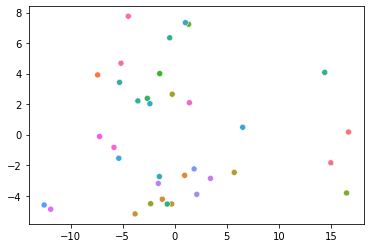

In [357]:
sns.scatterplot(pcs[:,0], pcs[:,1], hue =normalized_df.index, legend=False)

## Try Morgan fingerprints

In [382]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [383]:
morgan_fp = []
for smile in smiles:
    mol = Chem.MolFromSmiles(smile)
    fp1 = AllChem.GetHashedMorganFingerprint(mol,2, nBits=1024)
    array = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp1, array)
    print(array)
    morgan_fp.append(array)

[0 2 0 ... 0 0 0]
[0 2 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 6 0 ... 0 0 0]
[0 3 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 6 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 5 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [384]:
object_methods = [method_name for method_name in dir(fp1)
                  if callable(getattr(fp1, method_name))]
print(object_methods)

['GetLength', 'GetNonzeroElements', 'GetTotalVal', 'ToBinary', 'UpdateFromSequence', '__add__', '__and__', '__class__', '__delattr__', '__dir__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getinitargs__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__le__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__']


/home/icb/alessandro.palma/miniconda3/envs/imgCPA/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

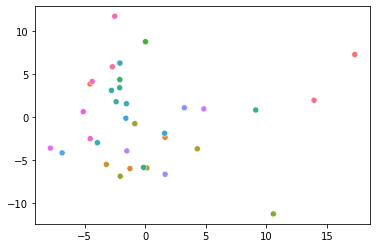

In [385]:
morgan_fp_array = np.array(morgan_fp) 
pca = PCA(n_components=2)
pcs = pca.fit_transform(morgan_fp)
sns.scatterplot(pcs[:,0], pcs[:,1], hue =normalized_df.index, legend=False)

In [387]:
morgan_fp_df = pd.DataFrame(morgan_fp_array)

In [388]:
morgan_fp_df.index = smiles

In [389]:
morgan_fp_df.to_csv

<bound method NDFrame.to_csv of                                                     0     1     2     3     \
CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]2...     0     2     0     0   
CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C@...     0     2     0     0   
CC(C)(C)n1nc(c2ccc(Cl)cc2)c3c(N)ncnc13                 0     0     0     0   
CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C...     0     6     0     0   
CC(C)[C@H](O)C1(NC(=O)[C@H](C)[C@@H]1O)C(=O)SC[...     0     3     0     0   
CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2                0     1     0     0   
CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[...     1     0     0     0   
CCC(C)C(NC(=O)OCc1ccccc1)C(=O)NC(CCC(=O)OC(C)(C...     0     6     0     0   
CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC4NCCc5cc(OC)c(O...     0     0     0     2   
CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(...     0     5     0     0   
CCC\\C=C\\C=C\\C(=O)O[C@H]1\\C(=C\\C(=O)OC)\\C[...     0     1     0     0   
CCOc1cc(OC[C@H]2CCCN2)c3c(Nc4cnn

In [390]:
model_name_morgan = 'MorganFP'
fname_morgan = f'{model_name_morgan}_embedding_{dataset_name}.csv'
embedding_dir = '/lustre/groups/ml01/workspace/alessandro.palma/imCPA/fluorescence/metadata_processed/embeddings'

In [391]:
morgan_fp_df.to_csv(os.path.join(embedding_dir, fname_morgan))